In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v1_base.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]


existing_hparams = TSTInfo.get_existing_hparams()
seeds = np.unique([h["seed"] for h in existing_hparams])
signal_ratios = np.unique([h["signal_ratio"] for h in existing_hparams])
n_3bs = np.unique([h["n_3b"] for h in existing_hparams])

  0%|          | 0/1 [00:00<?, ?it/s]

Sigma avg CR 2.4606009
Sigma avg bg4b CR 2.4606009
Sigma avg SR 6.988394
Sigma avg bg4b SR 6.988394
CR events 215805
SR events 70503


/tmp/ipykernel_3387104/2751369922.py:104: RuntimeWarning: invalid value encountered in divide
  sigma_CR = (hist_4b_CR - hist_3b_CR)  / std_est_CR
/tmp/ipykernel_3387104/2751369922.py:106: RuntimeWarning: invalid value encountered in divide
  sigma_bg4b_CR = (hist_bg4b_CR - hist_3b_CR)  / std_est_CR
/tmp/ipykernel_3387104/2751369922.py:110: RuntimeWarning: invalid value encountered in divide
  sigma_SR = (hist_4b_SR - hist_3b_SR)  / std_est_SR
/tmp/ipykernel_3387104/2751369922.py:112: RuntimeWarning: invalid value encountered in divide
  sigma_bg4b_SR = (hist_bg4b_SR - hist_3b_SR)  / std_est_SR


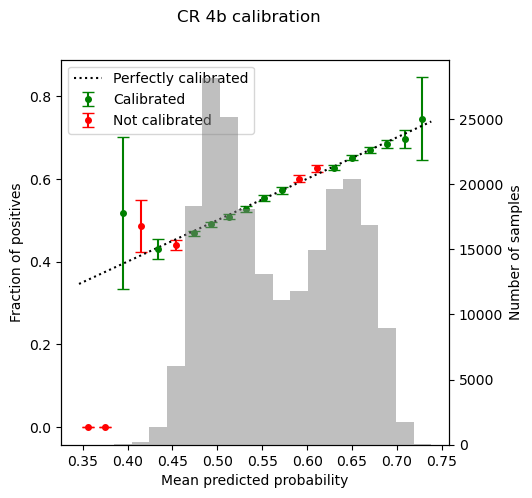

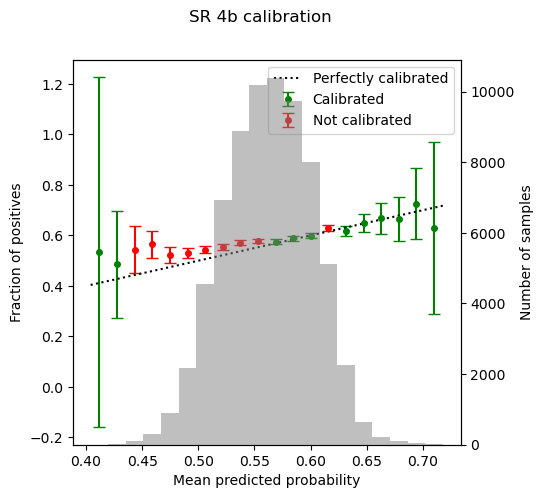

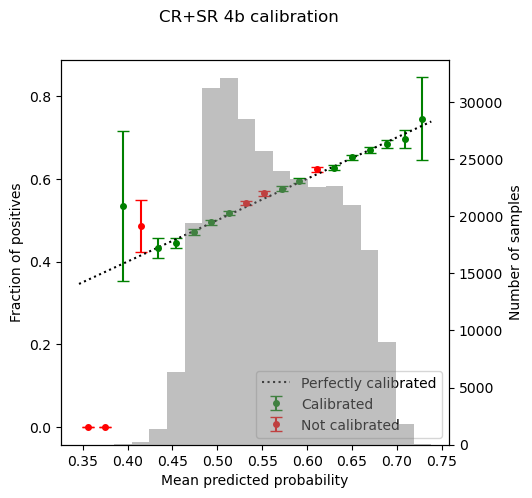

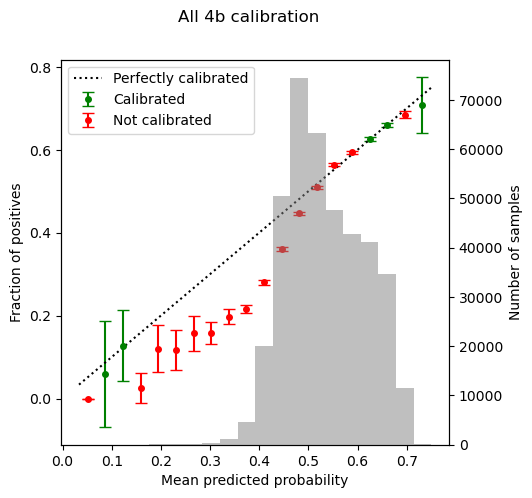

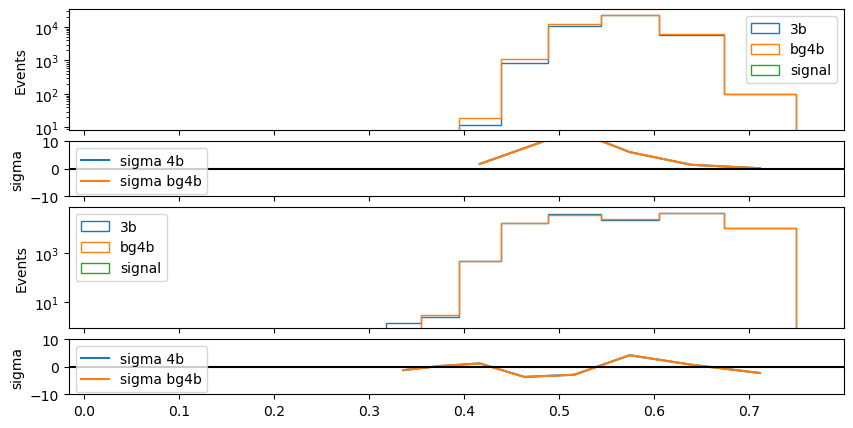

100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


In [155]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plots import calibration_plot

verbose = True
show_plots = True
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": 100_0000,
    "seed": 0,
    "signal_ratio": 0.0
}
hashes = TSTInfo.find(hparam_filter)

for tstinfo_hash in tqdm.tqdm(hashes):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()


    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    # probs_4b_est = fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]

    calibration_plot(probs_4b_est[in_CR],
                     events_tst[in_CR].is_4b,
                     sample_weights=events_tst[in_CR].weights,
                     title="CR 4b calibration")
    
    calibration_plot(probs_4b_est[in_SR],
                        events_tst[in_SR].is_4b,
                        sample_weights=events_tst[in_SR].weights,
                        title="SR 4b calibration")
    
    calibration_plot(probs_4b_est[in_CR | in_SR],
                     events_tst[in_CR | in_SR].is_4b,   
                        sample_weights=events_tst[in_CR | in_SR].weights,
                        title="CR+SR 4b calibration")
    
    calibration_plot(probs_4b_est,
                        events_tst.is_4b,
                        sample_weights=events_tst.weights,
                        title="All 4b calibration")
    

    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    
    events_tst.reweight(
        np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    events_tst_SR = events_tst[in_SR]
    events_tst_CR = events_tst[in_CR]

    hist_values = probs_4b_est
    # hist_values = events_tst.fvt_score
    # hist_values = SR_stats

    min_score = np.min(hist_values)
    max_score = np.max(hist_values)
    bins = np.geomspace(min_score, max_score, 30)
    midpoints = (bins[1:] + bins[:-1]) / 2

    hist_3b_CR, _ = np.histogram(hist_values[events_tst.is_3b & in_CR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_3b & in_CR])
    hist_bg4b_CR, _ = np.histogram(hist_values[events_tst.is_bg4b & in_CR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_bg4b & in_CR])
    hist_signal_CR, _ = np.histogram(hist_values[events_tst.is_signal & in_CR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_signal & in_CR])
    hist_4b_CR, _ = np.histogram(hist_values[events_tst.is_4b & in_CR], bins=bins,
                                weights=events_tst.weights[events_tst.is_4b & in_CR])

    hist_3b_SR, _ = np.histogram(hist_values[events_tst.is_3b & in_SR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_3b & in_SR])
    hist_bg4b_SR, _ = np.histogram(hist_values[events_tst.is_bg4b & in_SR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_bg4b & in_SR])
    hist_signal_SR, _ = np.histogram(hist_values[events_tst.is_signal & in_SR], bins=bins, 
                                weights=events_tst.weights[events_tst.is_signal & in_SR])
    hist_4b_SR, _ = np.histogram(hist_values[events_tst.is_4b & in_SR], bins=bins,
                                weights=events_tst.weights[events_tst.is_4b & in_SR])
    
    std_est_CR = np.sqrt(np.max([hist_4b_CR, hist_3b_CR], axis=0))
    sigma_CR = (hist_4b_CR - hist_3b_CR)  / std_est_CR
    sigma_avg_CR = np.sqrt(np.mean(sigma_CR[~np.isnan(sigma_CR)] ** 2))
    sigma_bg4b_CR = (hist_bg4b_CR - hist_3b_CR)  / std_est_CR
    sigma_avg_bg4b_CR = np.sqrt(np.mean(sigma_bg4b_CR[~np.isnan(sigma_bg4b_CR)] ** 2))
    
    std_est_SR = np.sqrt(np.max([hist_4b_SR, hist_3b_SR], axis=0))
    sigma_SR = (hist_4b_SR - hist_3b_SR)  / std_est_SR
    sigma_avg_SR = np.sqrt(np.mean(sigma_SR[~np.isnan(sigma_SR)] ** 2))
    sigma_bg4b_SR = (hist_bg4b_SR - hist_3b_SR)  / std_est_SR
    sigma_avg_bg4b_SR = np.sqrt(np.mean(sigma_bg4b_SR[~np.isnan(sigma_bg4b_SR)] ** 2))

    if verbose:
        print("Sigma avg CR", sigma_avg_CR)
        print("Sigma avg bg4b CR", sigma_avg_bg4b_CR)
        print("Sigma avg SR", sigma_avg_SR)
        print("Sigma avg bg4b SR", sigma_avg_bg4b_SR)
        print("CR events", len(events_tst_CR))
        print("SR events", len(events_tst_SR))

    if show_plots:
        fig = plt.figure(figsize=(10, 5))
        gs = GridSpec(6, 1, figure=fig)
        ax1 = fig.add_subplot(gs[0:2])
        
        hist_events_by_labels(events_tst_SR, hist_values[in_SR], bins, ax1)
        ax1.set_xlim(min_score - 0.05, max_score + 0.05)
        ax1.set_yscale("log")
        ax1.set_xlabel("FvT score")
        ax1.set_ylabel("Events")
        ax1.legend()

        ax3 = fig.add_subplot(gs[2])
        ax3.plot(midpoints, sigma_SR, label="sigma 4b")
        ax3.plot(midpoints, sigma_bg4b_SR, label="sigma bg4b")
        ax3.axhline(0, color="black")
        # ax3.set_xlabel("SR stats")
        ax3.set_ylabel("sigma")
        ax3.set_xlim(min_score - 0.05, max_score + 0.05)
        ax3.set_ylim(-10, 10)
        ax3.legend()

        ax2 = fig.add_subplot(gs[3:5])
        hist_events_by_labels(events_tst_CR, hist_values[in_CR], bins, ax2)
        ax2.set_xlim(min_score - 0.05, max_score + 0.05)
        ax2.set_yscale("log")
        ax2.set_xlabel("FvT score")
        ax2.set_ylabel("Events")
        ax2.legend()
        

        ax4 = fig.add_subplot(gs[5])
        ax4.plot(midpoints, sigma_CR, label="sigma 4b")
        ax4.plot(midpoints, sigma_bg4b_CR, label="sigma bg4b")
        ax4.axhline(0, color="black")
        # ax4.set_xlabel("SR stats")
        ax4.set_ylabel("sigma")
        ax4.set_xlim(min_score - 0.05, max_score + 0.05)
        ax4.set_ylim(-10, 10)
        ax4.legend()
        plt.show()

In [158]:
(events_tst.fvt_score - probs_4b_est)**2 * events_tst.weights

array([0.00033531, 0.00151364, 0.03417588, ..., 0.01729663, 0.00104144,
       0.00089053], dtype=float32)

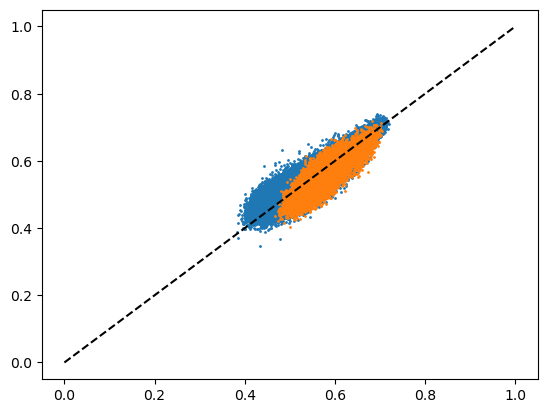

In [156]:
np.corrcoef([events_tst.fvt_score[in_CR], probs_4b_est[in_CR]])
np.corrcoef([events_tst.fvt_score[in_CR], probs_4b_est[in_CR]])

plt.plot(events_tst.fvt_score[in_CR], probs_4b_est[in_CR], "o", markersize=1)
plt.plot(events_tst.fvt_score[in_SR], probs_4b_est[in_SR], "o", markersize=1)
plt.plot([0, 1], [0, 1], "k--")
plt.show()
plt.close()

In [131]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": 100_0000,
    # "seed": lambda x: x < 10,
}

hashes = TSTInfo.find(hparam_filter)
tst_results = []

result_size = 0
for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()


    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)


    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    events_tst.reweight(
        np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    
    events_SR = events_tst[in_SR]
    events_CR = events_tst[in_CR]
    SR_stats_SR = SR_stats[in_SR]
    SR_stats_CR = SR_stats[in_CR]
    
    tst_results.append({
        "signal_ratio": signal_ratio,
        "seed": seed,
        "events_SR": events_SR,
        "events_CR": events_CR,
        "SR_stats_SR": SR_stats_SR,
        "SR_stats_CR": SR_stats_CR,
        "SR_cut": SR_cut,
        "CR_cut": CR_cut,
        "CR_model_output_CR": probs_4b_est[in_CR],
        "CR_model_output_SR": probs_4b_est[in_SR],
    })
    result_size += (
        events_SR.get_memory_usage() + events_CR.get_memory_usage() +
        SR_stats_SR.nbytes + SR_stats_CR.nbytes
    ) / 1024**2

    pbar.set_postfix({"Result size (MB)": result_size})

100%|██████████| 300/300 [33:09<00:00,  6.63s/it, Result size (MB)=1.85e+4]


In [132]:
def get_histogram_info(events, values, bins):
    assert len(events) == len(values)

    if isinstance(bins, int):
        bins = np.linspace(np.min(values), np.max(values), bins)
    
    hist_3b, _ = np.histogram(values[events.is_3b], bins=bins, weights=events.weights[events.is_3b])
    hist_bg4b, _ = np.histogram(values[events.is_bg4b], bins=bins, weights=events.weights[events.is_bg4b])
    hist_signal, _ = np.histogram(values[events.is_signal], bins=bins, weights=events.weights[events.is_signal])
    hist_4b, _ = np.histogram(values[events.is_4b], bins=bins, weights=events.weights[events.is_4b])

    std_est = np.sqrt(np.max([hist_4b, hist_3b], axis=0))
    sigma = (hist_4b - hist_3b)  / std_est
    sigma_avg = np.sqrt(np.mean(sigma[~np.isnan(sigma)] ** 2))
    sigma_bg4b = (hist_bg4b - hist_3b)  / std_est
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b[~np.isnan(sigma_bg4b)] ** 2))

    return {
        "hist_3b": hist_3b,
        "hist_bg4b": hist_bg4b,
        "hist_signal": hist_signal,
        "hist_4b": hist_4b,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
    }

In [153]:
tst_results_summary = []

for tst_result in tst_results:
    events_SR = tst_result["events_SR"]
    events_CR = tst_result["events_CR"]
    SR_stats_SR = tst_result["SR_stats_SR"]
    SR_stats_CR = tst_result["SR_stats_CR"]
    SR_cut = tst_result["SR_cut"]
    CR_cut = tst_result["CR_cut"]
    signal_ratio = tst_result["signal_ratio"]
    seed = tst_result["seed"]
    CR_model_output_CR = tst_result["CR_model_output_CR"]
    CR_model_output_SR = tst_result["CR_model_output_SR"]

    nbins = [10, 20, 30, 50, 100, 200]
    for nbin in nbins:
        # hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin)
        # hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin)
        hist_info_SR = get_histogram_info(events_SR, CR_model_output_SR, nbin)
        hist_info_CR = get_histogram_info(events_CR, CR_model_output_CR, nbin)

        tst_results_summary.append({
            "signal_ratio": signal_ratio,
            "seed": seed,
            "nbin": nbin,
            "sigma_avg_SR": hist_info_SR["sigma_avg"],
            "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
            "sigma_avg_CR": hist_info_CR["sigma_avg"],
            "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
        })

tst_results_summary_df = pd.DataFrame(tst_results_summary)

/tmp/ipykernel_3387104/359779080.py:13: RuntimeWarning: invalid value encountered in divide
  sigma = (hist_4b - hist_3b)  / std_est
/tmp/ipykernel_3387104/359779080.py:15: RuntimeWarning: invalid value encountered in divide
  sigma_bg4b = (hist_bg4b - hist_3b)  / std_est


In [154]:
from scipy import stats

sig_level = 0.05
z = stats.norm.ppf(1 - sig_level / 2)
tst_results_summary_df["rejected_SR"] = tst_results_summary_df["sigma_avg_SR"] > z
tst_results_summary_df["rejected_bg4b_SR"] = tst_results_summary_df["sigma_avg_bg4b_SR"] > z
tst_results_summary_df["rejected_CR"] = tst_results_summary_df["sigma_avg_CR"] > z
tst_results_summary_df["rejected_bg4b_CR"] = tst_results_summary_df["sigma_avg_bg4b_CR"] > z

tst_results_summary_df.groupby(["signal_ratio", "nbin"]).mean()

seed  sigma_avg_SR  sigma_avg_bg4b_SR  sigma_avg_CR  \
signal_ratio nbin                                                        
0.00         10    49.5      5.494922           5.494922      2.739472   
             20    49.5      4.014668           4.014668      2.269251   
             30    49.5      3.398778           3.398778      2.047462   
             50    49.5      2.797999           2.797999      1.842147   
             100   49.5      2.250341           2.250341      1.676919   
             200   49.5      1.916343           1.916343      1.576032   
0.01         10    49.5      6.126015           4.995630      2.609983   
             20    49.5      4.429435           3.677245      2.181474   
             30    49.5      3.720859           3.128530      1.987948   
             50    49.5      3.034325           2.601065      1.803994   
             100   49.5      2.397419           2.122239      1.663842   
             200   49.5      1.999880           1.830795      1.565839   
0.02         10    49.5     10.702777           4.534712      2.590451   
             20    49.5      7.562833           3.333929      2.176533   
             30    49.5      6.242629           2.855257      1.992538   
             50    49.5      4.947953           2.396578      1.814110   
             100   49.5      3.684913           1.979084      1.640719   
             200   49.5      2.828939           1.721750      1.554493   

                   sigma_avg_bg4b_CR  rejected_SR  rejected_bg4b_SR  \
signal_ratio nbin                                                     
0.00         10             2.739472         0.99              0.99   
             20             2.269251         0.99              0.99   
             30             2.047462         0.99              0.99   
             50             1.842147         0.94              0.94   
             100            1.676919         0.71              0.71   
             200            1.576032         0.32              0.32   
0.01         10             2.795705         1.00              0.98   
             20             2.279668         1.00              0.96   
             30             2.056921         0.98              0.91   
             50             1.847808         0.95              0.84   
             100            1.688681         0.79              0.61   
             200            1.577613         0.49              0.28   
0.02         10             2.857109         1.00              0.97   
             20             2.335347         1.00              0.93   
             30             2.110944         1.00              0.84   
             50             1.893994         1.00              0.76   
             100            1.687150         0.99              0.44   
             200            1.578616         0.98              0.14   

                   rejected_CR  rejected_bg4b_CR  
signal_ratio nbin                                 
0.00         10           0.86              0.86  
             20           0.73              0.73  
             30           0.56              0.56  
             50           0.28              0.28  
             100          0.06              0.06  
             200          0.00              0.00  
0.01         10           0.78              0.87  
             20           0.64              0.73  
             30           0.52              0.54  
             50           0.26              0.31  
             100          0.04              0.05  
             200          0.00              0.00  
0.02         10           0.79              0.84  
             20           0.68              0.74  
             30           0.53              0.63  
             50           0.22              0.37  
             100          0.03              0.07  
             200          0.00              0.00

In [136]:
tst_results_summary_df.to_csv(f"tst_results_summary_{experiment_name}.csv", index=False)